In [86]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import rasterio
import tarfile
import matplotlib.pyplot as plt
import random
import scipy

In [2]:
dir_original_images = r'G:\My Drive\2021fall\NRE5545\modules\project\data\1. original_images'
dir_unzipped_images = r'G:\My Drive\2021fall\NRE5545\modules\project\data\2. unzipped_images'
dir_processed_images = r'G:\My Drive\2021fall\NRE5545\modules\project\data\3. processed_images'

img_shape = (320, 320)
train_samples = 300

random.seed(1234)

In [3]:
def extract_file(fname, to_where = dir_unzipped_images):
#     if fname.endswith("tar.gz"):
#         tar = tarfile.open(fname, "r:gz")
#     elif fname.endswith("tar"):
    folder_name = os.path.join(to_where, os.path.basename(fname).replace('.tar',''))
    if not os.path.exists(folder_name):
        tar = tarfile.open(fname, "r:")
        os.mkdir(folder_name)
        tar.extractall(folder_name)
        tar.close()
    return folder_name

In [4]:
zip_files = glob.glob(os.path.join(dir_original_images, "*.tar"))
unzipped_folders=[extract_file(f, dir_unzipped_images) for f in zip_files]
unzipped_folders

['G:\\My Drive\\2021fall\\NRE5545\\modules\\project\\data\\2. unzipped_images\\LC08_L2SP_012031_20190706_20200827_02_T1',
 'G:\\My Drive\\2021fall\\NRE5545\\modules\\project\\data\\2. unzipped_images\\LC08_L2SP_012031_20200708_20200912_02_T1',
 'G:\\My Drive\\2021fall\\NRE5545\\modules\\project\\data\\2. unzipped_images\\LC08_L2SP_013031_20140731_20200911_02_T1',
 'G:\\My Drive\\2021fall\\NRE5545\\modules\\project\\data\\2. unzipped_images\\LC08_L2SP_013031_20190814_20200827_02_T1']

In [5]:
for folder in unzipped_folders:
    where_to_save = os.path.join(dir_processed_images,os.path.basename(folder))
    if not os.path.exists(where_to_save):
        os.mkdir(where_to_save)

    tif_files_extensions = [f'_SR_B{i}.TIF' for i in range(2,8)] + ['_QA_PIXEL.TIF']
    tif_files = np.array([rasterio.open(os.path.join(folder, os.path.basename(folder)+ ext)).read()[0] for ext in tif_files_extensions])

    # make x,y
    _, len_r, len_c = tif_files.shape
    up_left_c = list(range(0,len_c,img_shape[0]))[:-1]+[len_c-img_shape[0]]
    up_left_r = list(range(0,len_r,img_shape[1]))[:-1]+[len_r-img_shape[1]]
    up_left_cr = [(c,r) for c in up_left_c for r in up_left_r]

    for (c,r) in up_left_cr:
        img_slice = tif_files[:, r:r+img_shape[0], c:c+img_shape[1]]
        img_y = img_slice[-1]
        if sum(sum(img_y & 1)) < (0.5 * img_y.shape[0] * img_y.shape[1]):
            img_x = img_slice[:-1,:,:]
            
            img_x = np.moveaxis(img_x, 0, -1)
            
            img_x = img_x - np.mean(img_x)
            temptemp = max(img_x.min(), img_x.max(), key=abs)
            img_x= img_x.astype(np.float32)/temptemp
#             temp = np.expand_dims((img_y & (1<<3)),-1)
#             img_y= img_y.astype(np.float32)/(1<<3)
            temp = (img_y & (1<<3))
            a = sum(sum(temp == 0))
            b = temp.shape[0] * temp.shape[1]
            if 0.3 < a/b < 0.7:
                img_y = np.array([((temp==0)*1),((temp==(1<<3))*1)])
                img_y = np.moveaxis(img_y, 0, -1)
                tempx = os.path.join(where_to_save, f'x_{r}_{c}_{img_x.shape[0]}_{img_x.shape[1]}_{img_x.shape[2]}.npy')
                if not os.path.exists(tempx):
                    np.save(tempx,img_x)
                tempy = os.path.join(where_to_save, f'y_{r}_{c}_{img_y.shape[0]}_{img_y.shape[1]}_{img_y.shape[2]}.npy')
                if not os.path.exists(tempy):
                    np.save(tempy,img_y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

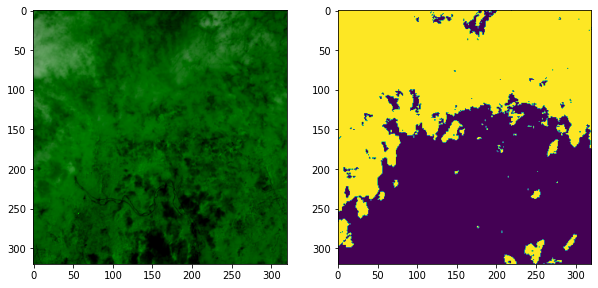

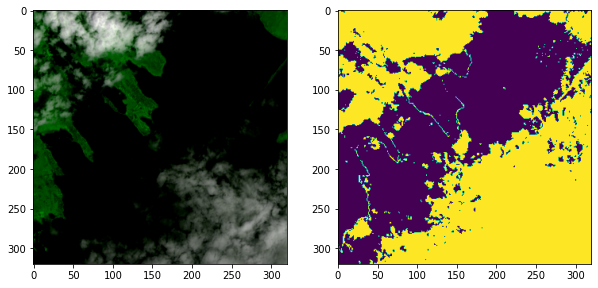

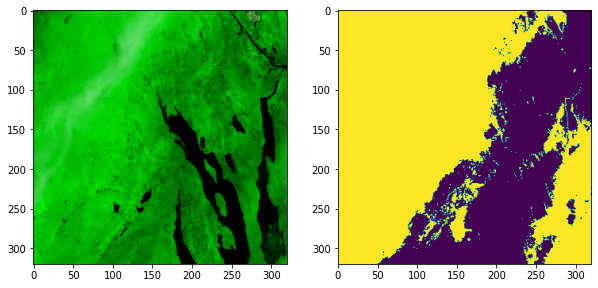

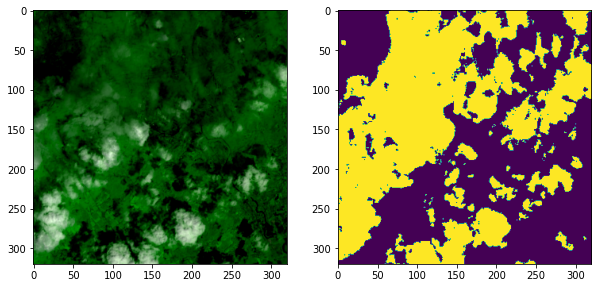

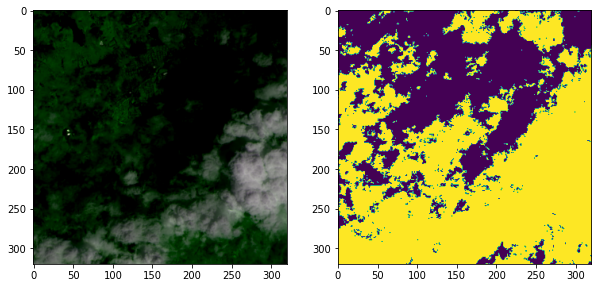

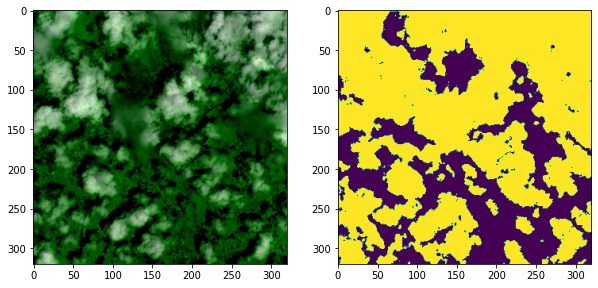

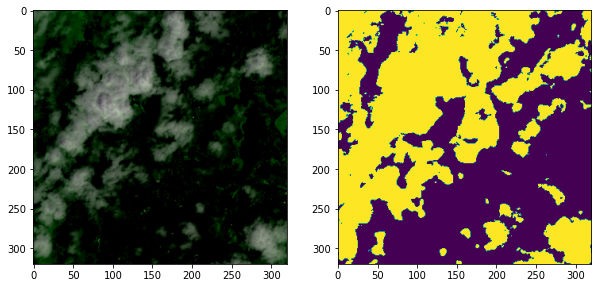

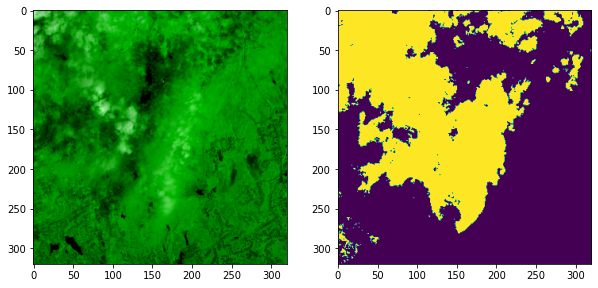

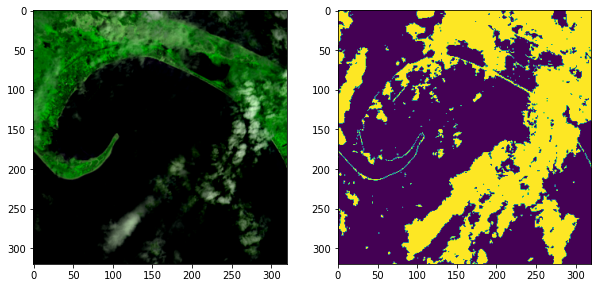

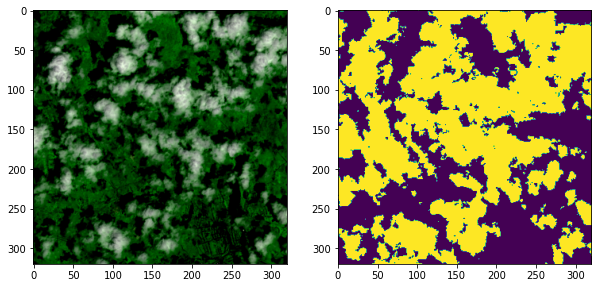

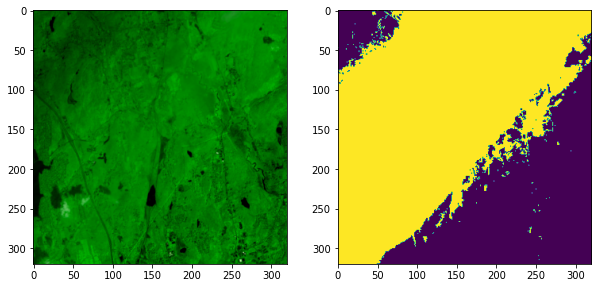

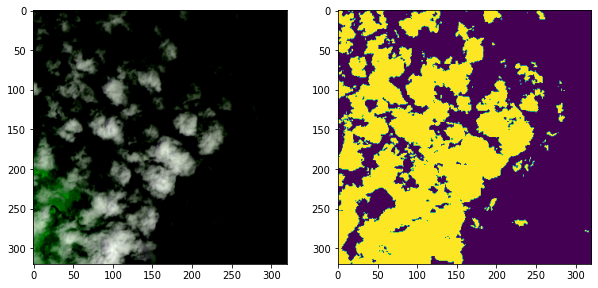

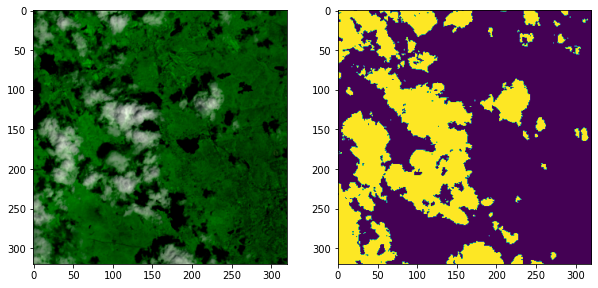

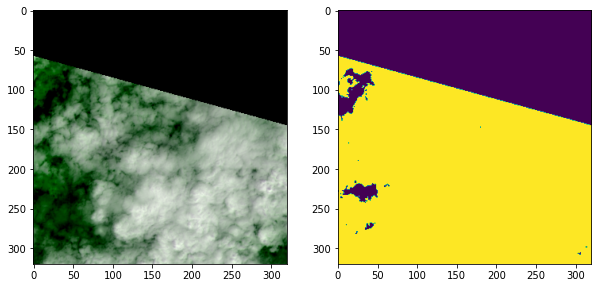

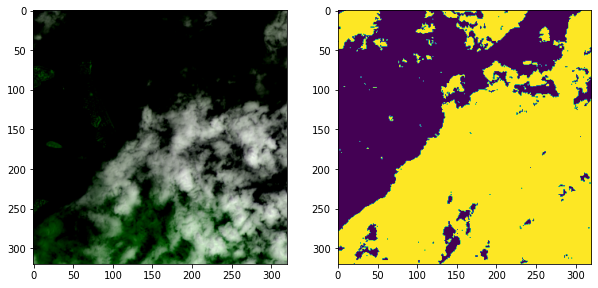

In [8]:
images = random.choices(glob.glob(os.path.join(dir_processed_images,"*/x*.npy")), k=15)
for f in images:
    image = np.load(f)
    img3 = image[:,:,[2,3,1]]
    f_mask = os.path.join(os.path.dirname(f), os.path.basename(f).replace('_6.npy','_2.npy').replace('x','y'))
    mask = np.load(f_mask)[:,:,1].astype(np.int)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10,5])
    ax1.imshow(img3)
    ax2.imshow(mask)    

In [9]:
images = glob.glob(os.path.join(dir_processed_images,"*/x*.npy"))
random.shuffle(images)
x = images
y = [os.path.join(os.path.dirname(f), os.path.basename(f).replace('_6.npy','_2.npy').replace('x','y')) for f in x]

train = pd.DataFrame()
train['x'] = x[:train_samples]
train['y'] = y[:train_samples]
# train.to_csv(os.path.join(dir_processed_images,'train.csv'), index = False)

validation = pd.DataFrame()
validation['x'] = x[train_samples:]
validation['y'] = y[train_samples:]
# validation.to_csv(os.path.join(dir_processed_images,'validation.csv'), index = False)